<a href="https://colab.research.google.com/github/ramtiin/Anomaly-detection-on-Stock-Market-using-Autoencoders/blob/main/Anomaly_detection_on_Stock_Market_using_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
'''
The code imports several libraries including numpy, pandas, tensorflow, yfinance, 
and matplotlib for various tasks such as data analysis, plotting graphs, and building the deep learning model.
'''

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,4.5) # Make the default figures a bit bigger
import numpy as np
import random
import pandas as pd
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [76]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


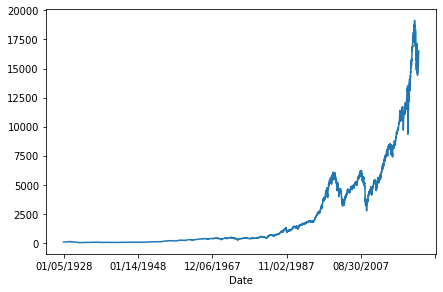

In [108]:
'''
Data preprocessing: The code downloads historical data for the S&P 500 stock market index
using the yfinance library, performs data cleaning, and normalization.
'''

import yfinance as yf
SP500 = yf.Ticker("^GSPC")

# get historical market data
SP500 = SP500.history(period="max")

SP500 = SP500.Close
SP500 = SP500.rolling(4).sum()
SP500 = SP500.dropna()
SP500.index = SP500.index.strftime('%m/%d/%Y')

SP500.plot()


In [110]:
'''
utoencoder Model: An autoencoder is implemented as a class AnomalyDetector that extends the tf.keras.models.Model class.
The autoencoder is composed of two parts: an encoder and a decoder.
The encoder reduces the dimensionality of the input data, and the decoder restores it to its original shape.
'''

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(30, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [111]:
'''
The autoencoder model is compiled with the adam optimizer and the mean absolute error (mae) as the loss function.
'''
autoencoder.compile(optimizer='adam', loss='mae')

In [112]:
'''
The function is intended to normalize a given data using MinMaxScaler, with a rolling window of the specified size. It returns the normalized data as a numpy array.
'''
def normalize_window_roll(data, window_size):
    X = []
    Y = []
    for i in range(0,len(data) - window_size,5):
        x_window = data.iloc[i:i+window_size]
        
        # Normalize the x_window and y_window
        scaler = MinMaxScaler()
        x_window = scaler.fit_transform(np.array(x_window).reshape(-1, 1))
        
        X.append(x_window)
    X =np.squeeze(np.array(X), axis=2)

    return X

In [113]:
X= normalize_window_roll(SP500,30)

In [114]:
train_size = int(0.7*X.shape[0])
test_size = int(0.1*X.shape[0])
val_size = int(0.2*X.shape[0])

X_train = X[:train_size]
X_test = X[train_size:train_size+test_size]
X_val = X[train_size+test_size:train_size+test_size+val_size]

In [115]:
'''
Training the model: The autoencoder is trained using the stock market data using the fit function.
An EarlyStopping callback is added to stop the training if the validation loss does not improve for 2 consecutive epochs.
'''
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
autoencoder.compile(optimizer='adam', loss='mae')

history = autoencoder.fit(X_train,X_train, epochs=40,
                    validation_data=(X_val, X_val),
                    batch_size=16,
                    callbacks=[early_stopping])

Epoch 1/40
209/209 [==============================] - 1s 3ms/step - loss: 0.2193 - val_loss: 0.1686
Epoch 2/40
209/209 [==============================] - 1s 3ms/step - loss: 0.1417 - val_loss: 0.1201
Epoch 3/40
209/209 [==============================] - 1s 3ms/step - loss: 0.1118 - val_loss: 0.1041
Epoch 4/40
209/209 [==============================] - 1s 3ms/step - loss: 0.0978 - val_loss: 0.0937
Epoch 5/40
209/209 [==============================] - 1s 3ms/step - loss: 0.0878 - val_loss: 0.0855
Epoch 6/40
209/209 [==============================] - 1s 4ms/step - loss: 0.0813 - val_loss: 0.0822
Epoch 7/40
209/209 [==============================] - 1s 4ms/step - loss: 0.0775 - val_loss: 0.0786
Epoch 8/40
209/209 [==============================] - 1s 4ms/step - loss: 0.0735 - val_loss: 0.0746
Epoch 9/40
209/209 [==============================] - 1s 4ms/step - loss: 0.0700 - val_loss: 0.0710
Epoch 10/40
209/209 [==============================] - 1s 3ms/step - loss: 0.0678 - val_loss: 0.0702

105/105 [==============================] - 0s 2ms/step


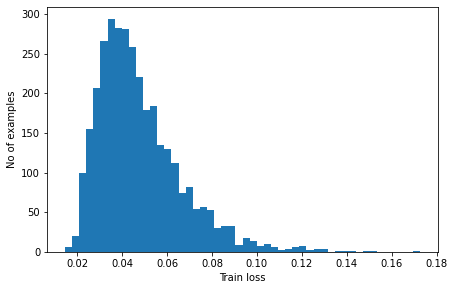

In [154]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
reconstructions = autoencoder.predict(X_train)
train_loss = tf.keras.losses.mae(reconstructions, X_train)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [155]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.06632115902964378


15/15 [==============================] - 0s 6ms/step


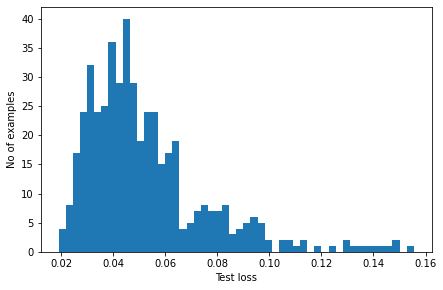

In [156]:
reconstructions = autoencoder.predict(X_test)
test_loss = tf.keras.losses.mae(reconstructions, X_test)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [157]:
#Source: https://www.tensorflow.org/tutorials/generative/autoencoder
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)


In [158]:
preds = predict(autoencoder, X_test, threshold)

In [159]:
anomalous_test_data = X_test[np.where(preds==False)]

Plotting of some anomalous detected data

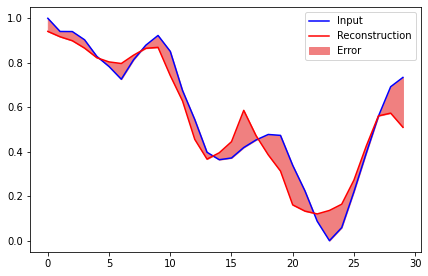

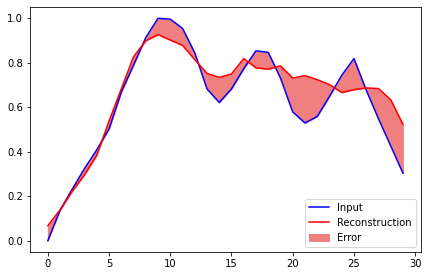

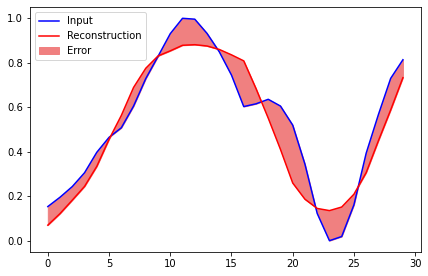

In [160]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

for p in [1,10,20]:
  plt.plot(anomalous_test_data[p], 'b')
  plt.plot(np.arange(0,X.shape[1]),decoded_data[p], 'r')
  plt.fill_between(np.arange(X.shape[1]), decoded_data[p], anomalous_test_data[p], color='lightcoral')
  plt.legend(labels=["Input", "Reconstruction", "Error"])
  plt.show()